In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt

In [3]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [4]:
df = pd.read_csv("datasets\covid19postvaxstatewidestats.csv")

df = df[df['unvaccinated_cases_per_100k'].notna()]

df = df.reset_index(drop=True)

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\dangn\AppData\Local\Temp\ipykernel_22956\2108600221.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("datasets\covid19postvaxstatewidestats.csv")


In [5]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

df['date'] = (df['date'] - df['date'].min()).dt.days

df['date']

0        0
1        1
2        2
3        3
4        4
      ... 
778    778
779    779
780    780
781    781
782    782
Name: date, Length: 783, dtype: int64

In [6]:
df_unvac = df[['unvaccinated_cases_per_100k', 'unvaccinated_hosp_per_100k', 'unvaccinated_deaths_per_100k']].values

df_unvac

array([[27.25129451,  1.48340084,  0.06770208],
       [25.07236232,  1.36051892,  0.07803273],
       [23.26814625,  1.29689178,  0.08767719],
       ...,
       [ 8.26811575,  0.55205966,  0.0485608 ],
       [ 8.15735645,  0.5700691 ,  0.06135273],
       [ 8.00836675,  0.5804276 ,  0.0562529 ]])

In [7]:
def sequence_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i+time_step,:])
    return np.array(X), np.array(y)

In [8]:
split_index = int(len(df_unvac) * 0.8)

train_unvac = df_unvac[:split_index]
test_unvac = df_unvac[split_index:]

X_train, y_train = sequence_data(train_unvac, 10)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

X_test, y_test = sequence_data(test_unvac, 10)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [9]:
X_train.shape

(615, 10, 3)

In [10]:
y_train.shape

(615, 3)

In [9]:
def model_builder(hp):
    model = Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    hp_dense_layers = hp.Choice('num_dense_layers', [1,2,3])

    hp_layer_1 = hp.Int('layer_1', min_value=16, max_value=512, step=16)

    hp_layer_2 = hp.Int('layer_2', min_value=16, max_value=512, step=16)

    hp_layer_3 = hp.Int('layer_3', min_value=16, max_value=512, step=16)

    # hp_layer_4 = hp.Int('layer_4', min_value=16, max_value=512, step=16)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units = hp_layer_1, activation=hp_activation, input_shape = (X_train.shape[1],X_train.shape[2])))

    model.add(Dense(units = hp_layer_2, activation = hp_activation))

    if hp_dense_layers >= 2:
        model.add(Dense(units = hp_layer_3, activation = hp_activation))
    # if hp_dense_layers == 3:
    #     model.add(Dense(units = hp_layer_4, activation = hp_activation))

    model.add(Dense(units=3, activation=hp_activation))


    model.compile(optimizer = Adam(learning_rate=hp_learning_rate), loss='mse', metrics=['mae'])

    return model

In [10]:
tuner = kt.Hyperband(model_builder, 
                     objective='val_mae',
                     max_epochs=10,
                     factor = 3,
                     directory = 'dir',
                     project_name = 'one')

Reloading Tuner from dir\one\tuner0.json


In [11]:
stop_early = EarlyStopping(monitor = 'val_mae', patience = 5)

In [14]:
tuner.search(X_train, y_train, epochs=50, validation_data=[X_test, y_test], callbacks=[stop_early])

Trial 30 Complete [00h 00m 03s]
val_mae: 7.7461957931518555

Best val_mae So Far: 0.5518389940261841
Total elapsed time: 00h 01m 26s


In [12]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [16]:
print("The best hyperparameters are:")
for key, value in best_hp.values.items():
    print(f"{key}: {value}")

The best hyperparameters are:
activation: relu
num_dense_layers: 3
layer_1: 496
layer_2: 464
layer_3: 80
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014


In [17]:
model =  tuner.hypermodel.build(best_hp)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 496)            │       992,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 464)            │       230,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │        37,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,051 (4.81 MB)

 Trainable params: 1,260,051 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Test performance of regularizers

def model_regularizers(hp):
    model = Sequential()

    hp_dropout = hp.Choice('dropout_rate', values=[0.0, 0.2, 0.3, 0.4, 0.5])
    hp_l2_reg = hp.Choice('l2_reg_strength', values=[0.0, 1e-2, 1e-3, 1e-4])

    model.add(LSTM(units = best_hp.get("layer_1"), activation=best_hp.get("activation"), input_shape = (X_train.shape[1],X_train.shape[2]),  kernel_regularizer=l2(hp_l2_reg)))
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(units = best_hp.get("layer_2"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
    model.add(Dropout(rate=hp_dropout))

    if best_hp.get("num_dense_layers") >= 2:
        model.add(Dense(units = best_hp.get("layer_3"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
        model.add(Dropout(rate=hp_dropout))
    # if best_hp.get("num_dense_layers") == 3:
    #     model.add(Dense(units = best_hp.get("layer_4"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
    #     model.add(Dropout(rate=hp_dropout))

    model.add(Dense(units=3, activation=best_hp.get("activation")))

    model.compile(optimizer = Adam(learning_rate=best_hp.get("learning_rate")), loss='mse', metrics=['mae'])

    return model

    

In [19]:
tuner = kt.Hyperband(model_regularizers, 
                     objective='val_mae',
                     max_epochs=10,
                     factor = 3,
                     directory = 'dir',
                     project_name = 'second')

In [20]:
tuner.search(X_train, y_train, epochs=50, validation_data=[X_test, y_test], callbacks=[stop_early])

Trial 28 Complete [00h 00m 08s]
val_mae: 1.3452059030532837

Best val_mae So Far: 0.917392909526825
Total elapsed time: 00h 02m 07s


In [21]:
best_hp1 = tuner.get_best_hyperparameters(num_trials=1)[0]

In [22]:
print("The best hyperparameters are:")
for key, value in best_hp1.values.items():
    print(f"{key}: {value}")

The best hyperparameters are:
dropout_rate: 0.0
l2_reg_strength: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [14]:
model_multivariate = tuner.hypermodel.build(best_hp)
model_multivariate.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 496)            │       992,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 464)            │       230,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │        37,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,051 (4.81 MB)

 Trainable params: 1,260,051 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model_multivariate.fit(X_train, y_train, epochs = 50, validation_data = [X_test, y_test])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3330.0232 - mae: 18.0191 - val_loss: 83.5649 - val_mae: 5.3908
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1031.2592 - mae: 8.5237 - val_loss: 14.8768 - val_mae: 2.5559
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 214.2545 - mae: 4.2984 - val_loss: 9.2443 - val_mae: 1.8091
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 58.5450 - mae: 2.8920 - val_loss: 3.4338 - val_mae: 1.3442
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 37.9672 - mae: 2.2161 - val_loss: 2.7044 - val_mae: 1.1764
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 36.8854 - mae: 2.2421 - val_loss: 2.8159 - val_mae: 1.0920
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 37.1784 - mae: 2.2411 - val_loss: 2.2022 - val_mae: 0.9752
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 38.5291 - mae: 2.2445 - val_loss: 2.2915 - val_mae: 1.0117
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/st

In [16]:
split_index = int(len(df_unvac) * 0.8)

train_vac = df_unvac[:split_index]
test_vac = df_unvac[split_index:]

X_test, y_test = sequence_data(test_vac, 10)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


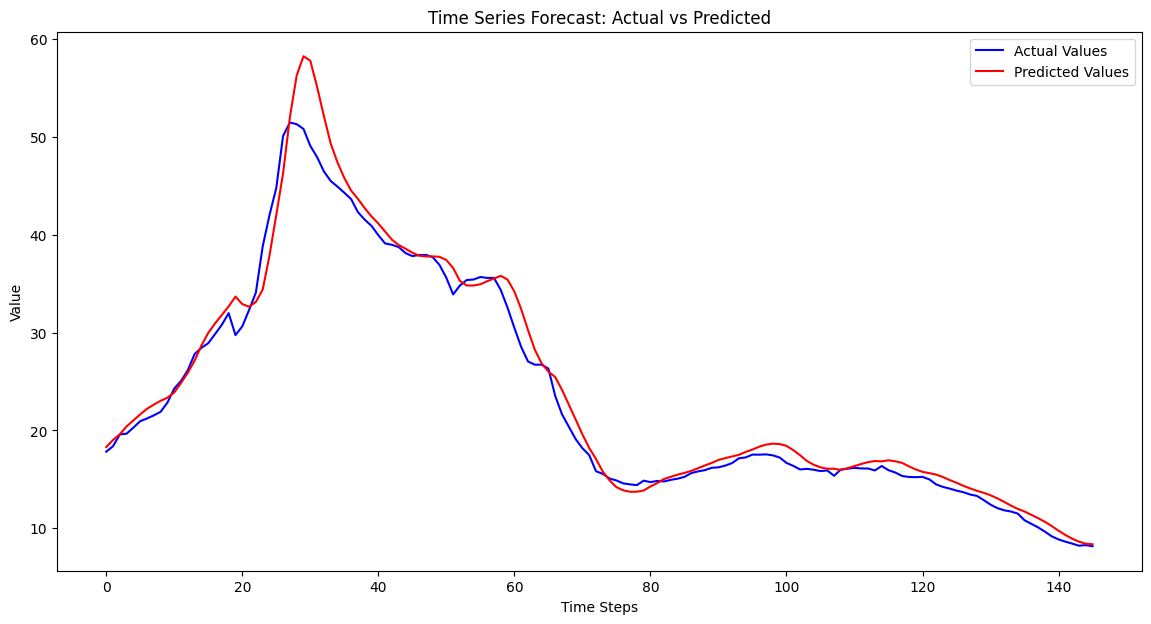

In [17]:
predictions_vac = model_multivariate.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(y_test[:,0], label='Actual Values', color='blue')
plt.plot(predictions_vac[:,0], label='Predicted Values', color='red')
plt.title('Time Series Forecast: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
model_multivariate.save('model/LSTM_multivariate_unvac.keras')